# Kupffer Analysis Data Processing

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df

# Define Functions

## Run Model

In [2]:
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''

    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))

    true_ids = [x[0] for x in index_label_tuples if x[1]]

    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]

    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]

    return training_features, test_features, training_labels, test_labels

def run_f_test(X, y, classifier):
    """run F test. takes test data values, label values
    and classifier fit with training values and returns
    F statistic table taken from:
    https://stackoverflow.com/questions/27928275/
    find-p-value-significance-in-scikit-learn-linearregression"""
    
    from scipy import stats
    
    # filter out rows/cols with all zeros - otherwise matrix becomes
    # singular and variance cannot be calculated using matrix alg
    nonzero_cols = (X != 0).any()
    nonzero_rows = (X != 0).any(1)
    X_filt = X.loc[nonzero_rows.values, nonzero_cols.values]
    y_filt = y[nonzero_rows.values]
    pred_filt = classifier.predict(X)[nonzero_rows.values]
    coef_filt = classifier.coef_[nonzero_cols.values]
    
    # calculate variance and significance
    MSE = (sum((y_filt.values.flatten()-pred_filt)**2))/(len(X_filt)-len(X_filt.columns)) # mean squared errror
    var_b = MSE*(np.linalg.inv(np.dot(X_filt.T,X_filt)).diagonal()) # variance
    sd_b = np.sqrt(var_b) # std err
    ts_b = coef_filt / sd_b # t values
    # p value is 2 tailed so 2x cdf of standardized coefficient value
    # with df of n nonzero tfs - 1
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_filt)-1))) for i in ts_b]

    # construct data frame to return
    result = pd.DataFrame({"Coefficients":coef_filt,
                          "Standard Errors": sd_b,
                          "t values": ts_b,
                          "Probabilites": p_values},
                         index=X_filt.columns.values)
    
    return result

def train_classifier(features,
                     labels,
                     membership=None,
                     model='Lasso',
                     stratify=False,
                     with_background=False,
                     numIterations=5,
                     test_size=0.5,
                     alpha = 1.0):
    start = time.time()
    all_rocs = []
    all_precisions = []
    all_coefficients = []
    all_scores = []
    all_testLabels = []
    all_r=[]
    all_sig=[]
    scaler = preprocessing.StandardScaler()
    for i in range(numIterations):
        iter_start = time.time()
        print('training iteration:', i+1)
        
        # convert labels to log transform
        log2_labels = np.log(labels + 1)
        log2_labels = log2_labels.loc[features.index.tolist(), :]

        # split data into training and test sets    
        if stratify:
            training_features, test_features, training_labels, test_labels = train_test_split(
                features,
                log2_labels[1],
                test_size=test_size,
                stratify=membership.loc[features.index.tolist(), :])
        else:
            training_features, test_features, training_labels, test_labels = get_split(
                features,
                log2_labels[1],
                test_size=test_size)
        # standardize training features
        standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
        standardized_training_features.columns = training_features.columns.values
        standardized_training_features.index = training_features.index.values

        # standardize test features
        standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
        standardized_test_features.columns = test_features.columns.values
        standardized_test_features.index = test_features.index.values

        #  Train affinity classifier
        if model=='Lasso':
            classifier = sklearn.linear_model.Lasso(alpha=0.1,
                                                    fit_intercept=False,
                                                    normalize=False,
                                                    max_iter=10**4)
            classifier.fit(training_features, training_labels)
        elif model=='Linear':
            classifier = sklearn.linear_model.LinearRegression(fit_intercept=False,
                                                normalize=False)
            classifier.fit(training_features, training_labels)
        
        # get predictions and score
        predictions=classifier.predict(test_features)
        current_r, current_p = scipy.stats.pearsonr(
            predictions.flatten(),
            test_labels.values.flatten())
        
        # retrieve coefficients
        current_coefficients = classifier.coef_.flatten()

        # all_rocs.append(current_roc)
        # all_precisions.append(current_precision)
        all_coefficients.append(current_coefficients)
        # all_scores.append(probas)
        all_testLabels.append(test_labels)
        all_r.append(current_r)
        
        iter_end = time.time()
        
        print('running f test')
        
        f_results = run_f_test(test_features, test_labels, classifier)
        current_sig = f_results['Probabilites']
        all_sig.append(current_sig)

        print('iteration training time:', iter_end-iter_start,
              'pearson r', current_r)
        
        
    end = time.time()

    # convert coefficients into data frame
    all_coefficients = pd.DataFrame(np.array(all_coefficients)).T
    all_coefficients.index = features.columns.values
    
    # convert f test significance into data frame
    all_sig = pd.DataFrame(all_sig).T
    
    print('Total time:', end - start)

    results = (# all_rocs,
               # all_precisions,
               all_coefficients,
               # all_scores,
               all_r,
               all_testLabels,
               all_sig)
    
    return results

def read_labels(label_path):
    '''
    reads label files created by create_features.py and returns a pandas Series representation
    '''
    indices = []
    vals = []
    with open(label_path) as f:
        data = f.readlines()
    for line in data:
        tokens = line.strip().split()
        indices.append(tokens[0])
        if tokens[1] == '1':
            vals.append(True)
        else:
            vals.append(False)
    to_return = pd.Series(vals, index=indices)
    return to_return

def write_classifier_results(results, output_path, feature_path):
    '''
    writes results of train_clasifier as tsv files
    '''
    # all_rocs = results[0]
    # all_precisions = results[1]
    all_coefficients = results[0]
    # all_scores = results[3]
    all_r = results[1]
    all_test_labels = results[2]
    all_sig = results[3]
    
    #if 'combined' in feature_path:
    #    file_name = feature_path.replace('_combined_features.tsv', '')
    #else:
    file_name = output_path + feature_path.split('/')[-1]
    file_name = file_name.replace('_features.tsv', '')

    print('outputting file to', file_name)

    performance_frame = pd.DataFrame({'r':all_r})
    performance_frame.to_csv(file_name+'_performance.tsv', sep='\t', index=False)
    all_coefficients.to_csv(file_name+'_coefficients.tsv',sep='\t')
    all_sig.to_csv(file_name+'_significance.tsv', sep='\t')

def run_train_classifier(feature_path,
                     label_path,
                     membership_path=None,
                     output_path='./',
                     model='Lasso',
                     num_iterations=5,
                     test_fraction=0.5,
                     stratify=False,
                     alpha=1.0):
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)

    # read in features
    print('reading features and labels')
    feature_frame = pd.read_csv(feature_path, sep='\t', index_col=0)

    
    # read in labels
    labels = pd.read_csv(label_path, sep='\t',
                         index_col=0, header=None)
    
    if stratify:
        membership = pd.read_csv(membership_path, sep='\t',
                             index_col=0, header=None)
    else:
        membership = None

    print('training classifier for', feature_path)
    results = train_classifier(feature_frame,
                 labels,
                 membership,
                 model=model,
                 numIterations=num_iterations,
                 test_size=test_fraction,
                 stratify=stratify,
                 alpha = alpha)
    print('writing results')
    write_classifier_results(results, output_path, feature_path)


## Set working directory

In [3]:
workingDirectory = '/home/h1bennet/liverStrains/results/180522_H3K27Ac_TBA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Script for testing model

In [7]:
tst_features = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_features.tsv',
                           sep='\t',
                           index_col=0)
tst_labels = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_labels.tsv', sep='\t',
                         index_col=0, header=None, names=['pos', 'h3k27ac'])
tst_labels = tst_labels.loc[tst_features.index.tolist(), :]

tst_membership = pd.read_csv('./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_membership.tsv', sep='\t',
                            index_col=0, header=None, names=['pos', 'mem'])
tst_membership = tst_membership.loc[tst_features.index.tolist(), :]

In [8]:
log2_labels = np.log(tst_labels + 1)

In [9]:
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

training_features, test_features, training_labels, test_labels = train_test_split(
    tst_features,
    log2_labels,
    # stratify=tst_membership.loc[tst_features.index.tolist()],
    train_size=0.5)

In [10]:
scaler = preprocessing.StandardScaler()

# standardize training features
standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
standardized_training_features.columns = training_features.columns.values
standardized_training_features.index = training_features.index.values

# standardize test features
standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
standardized_test_features.columns = test_features.columns.values
standardized_test_features.index = test_features.index.values

#  Train affinity classifier
# classifier = sklearn.linear_model.LinearRegression(fit_intercept=False, normalize=False)
classifier = sklearn.linear_model.Lasso(alpha=0.10, fit_intercept=False, normalize=False)
classifier.fit(standardized_training_features, training_labels)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
import scipy
predictions=classifier.predict(test_features)
scipy.stats.pearsonr(predictions.flatten(), test_labels.values.flatten())

(0.28201296526774849, 3.9452753259170198e-297)

# Train model - log2(h3k27Ac tags) in open chromatin regions

In [6]:
for tba_file in os.listdir('./tba_output'):
    if 'features.tsv' in tba_file:
    
        if 'combined' in tba_file:
            run_train_classifier('./tba_output/'+tba_file,
                                 './tba_output/'+tba_file.replace('features', 'labels'),
                                 './tba_output/'+tba_file.replace('features', 'membership'),
                                 output_path='./tba_output/',
                                 model='Lasso',
                                 stratify=True,
                                 num_iterations=3,
                                 alpha=0.1)
        else:    
            run_train_classifier('./tba_output/'+tba_file,
                                 './tba_output/'+tba_file.replace('features', 'labels'),
                                 './tba_output/'+tba_file.replace('features', 'membership'),
                                 output_path='./tba_output/',
                                 model='Lasso',
                                 stratify=False,
                                 num_iterations=3,
                                 alpha=0.1)   

reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training time: 6.034606456756592 pearson r 0.553854450168
training iteration: 2
running f test
iteration training time: 6.559443950653076 pearson r 0.549890303695
training iteration: 3
running f test
iteration training time: 6.039068222045898 pearson r 0.553171267029
Total time: 20.530979871749878
writing results
outputting file to ./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4neg_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training time: 11.397413492202759 pearson r 0.552163748131
training iteration: 2
running f test
iteration training time: 11.300942659378052 pearson r 0.547069908483
training iteration: 3
running f test
iteration training time: 10.62598443031311 pears

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


running f test
iteration training time: 19.641648054122925 pearson r 0.319535236735
training iteration: 2
running f test
iteration training time: 18.769538164138794 pearson r 0.314068034956
training iteration: 3
running f test
iteration training time: 18.49258279800415 pearson r 0.328182222693
Total time: 57.621497631073
writing results
outputting file to ./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_ccl4_6wk_peaks_features.tsv
training iteration: 1
running f test
iteration training time: 5.789808750152588 pearson r 0.357240831073
training iteration: 2
running f test
iteration training time: 6.196161508560181 pearson r 0.365420566318
training iteration: 3
running f test
iteration training time: 7.307759523391724 pearson r 0.366577804031
Total time: 19.98506212234497
writing results
outputting file to ./tba_output/ncorwt_kupffertim4pos_ccl4_6wk_peaks
reading features and labels
training class

# Plot Results

In [7]:
%%bash
if [ ! -d ./figures/ ]; then mkdir ./figures; fi

### Read in sample weights

In [8]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'combined' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:4])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### Read in sample probabilties

In [9]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'combined' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:4])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

In [10]:
mean_pval_frame.columns

Index(['ncorwt_kupffertim4neg_nashdiet_20wk', 'ncorwt_kupffertim4pos_ccl4_6wk',
       'ncorwt_kupffertim4pos_control_0wk',
       'ncorwt_kupffertim4pos_control_20wk',
       'ncorwt_kupffertim4pos_nashdiet_20wk'],
      dtype='object')

### Plot all Motifs Significance values

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


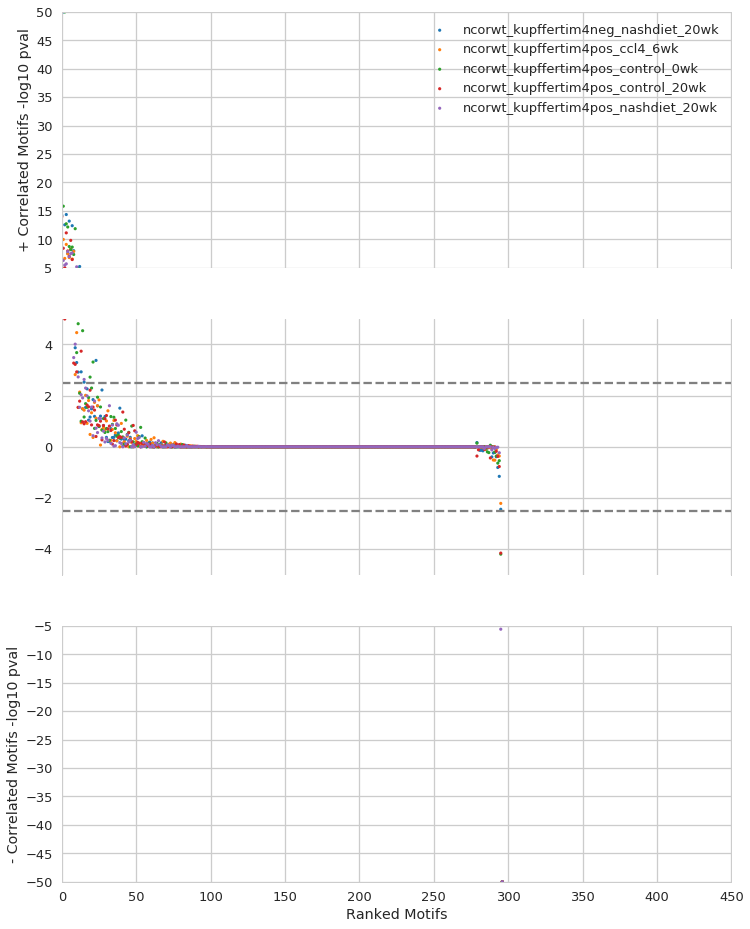

In [11]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,450)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')

    plt.savefig('./figures/tba_s_plot.pdf',bbox_inches='tight')

This s curve shows that almost all of the transcription factors that were weighted by LASSO were given positive weights. Negative weights were very rare

# Heatmap of Model Weights
___
Calculating a p value for Lasso seems particularly frought/difficult so we will skip that aspect of analysis for now. Instead lets take a look at the model weights and see how they are changing from sample to sample

In [31]:
samp_order = ['ncorwt_kupffertim4pos_control_0wk',
              'ncorwt_kupffertim4pos_nashdiet_20wk',
              'ncorwt_kupffertim4neg_nashdiet_20wk',
              'ncorwt_kupffertim4pos_ccl4_6wk'
]

In [32]:
# Check how many TFs were assigned values by Lasso: 47 TFs were assigned values across all 5 samples.
(mean_weights_frame != 0).sum(1).value_counts()

0    181
5     57
1     24
3     13
2     13
4     11
dtype: int64

top 10 average weight motifs

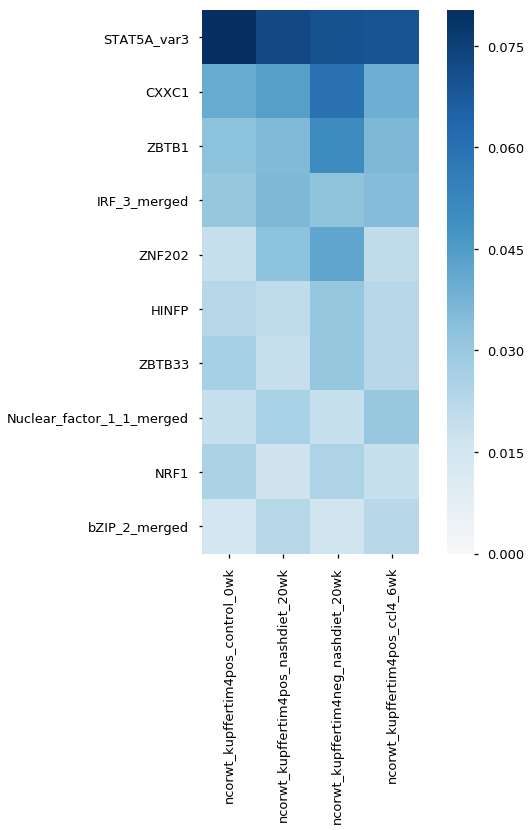

In [42]:
weights = mean_weights_frame.reindex(mean_weights_frame.mean(1).sort_values(ascending=False).index)
weights = weights.iloc[:10, :]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(weights.loc[:, samp_order],
     center=0,
     vmin=0,
     vmax=mean_weights_frame.values.max(),
     cmap='RdBu',
     square=True,
     ax=ax)
pos = hm.get_position()

In [39]:
weights.values.max()

0.046912093221899431

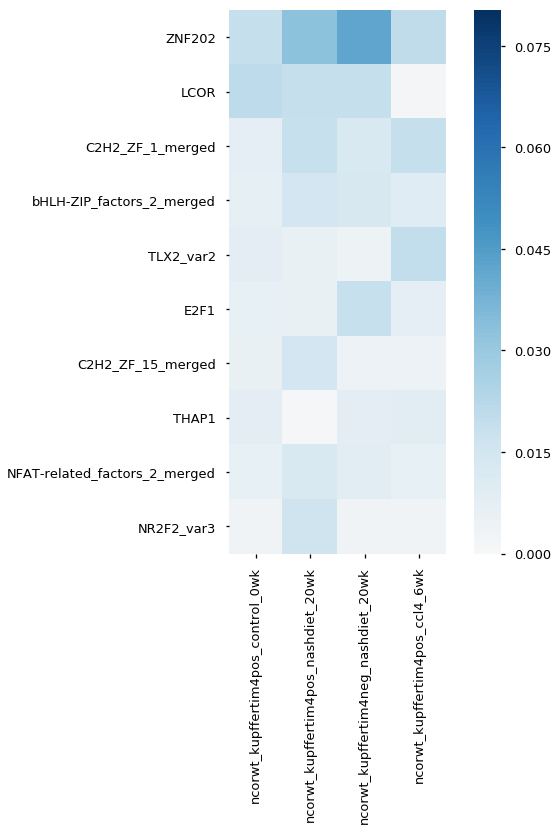

In [41]:
# select TFs of interest for plotting

# option: select TFs assigned weights by every LASSO model
# weights = mean_weights_frame.loc[(mean_weights_frame != 0).all(1), :]
# option: select TFs with a 2 fold change in magnitude across samples
# have to combine this with a minimum threshold bc if all 0's but also one very low weight then this will be infinite
weights = mean_weights_frame.loc[(np.abs(mean_weights_frame).max(1) / np.abs(mean_weights_frame).min(1) >= 2), :]
weights = weights.loc[(np.abs(mean_weights_frame) >= 0.01).any(1), :]
weights = weights.reindex(weights.mean(1).sort_values(ascending=False).index)
weights = weights.iloc[:10, :]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(weights.loc[:, samp_order],
     center=0,
     vmin=0,
     vmax=mean_weights_frame.values.max(),
     cmap='RdBu',
     square=True,
     ax=ax)
pos = hm.get_position()

# Run as pure linear regression

In [43]:
if not os.path.isdir('./tba_output_linreg'):
    os.mkdir('./tba_output_linreg')

In [44]:
for tba_file in os.listdir('./tba_output'):
    if 'features.tsv' in tba_file:
        run_train_classifier('./tba_output/'+tba_file,
                            './tba_output/'+tba_file.replace('features', 'labels'),
                            './tba_output/'+tba_file.replace('features', 'membership'),
                            output_path='./tba_output_linreg/',
                            model='Linear',
                            stratify=False,
                            num_iterations=3
                            )   

reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1


/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


running f test
iteration training time: 2.1776349544525146 pearson r 0.576445499004
training iteration: 2
running f test
iteration training time: 2.140759229660034 pearson r 0.577690926532
training iteration: 3
running f test
iteration training time: 2.2670998573303223 pearson r 0.576954973985
Total time: 7.845601797103882
writing results
outputting file to ./tba_output_linreg/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined
reading features and labels
training classifier for ./tba_output/ncorwt_kupffertim4neg_nashdiet_20wk_peaks_combined_features.tsv
training iteration: 1
running f test
iteration training time: 3.348414897918701 pearson r 0.575533927372
training iteration: 2
running f test
iteration training time: 3.5647780895233154 pearson r 0.56627691879
training iteration: 3
running f test
iteration training time: 3.4370357990264893 pearson r 0.572611211768
Total time: 11.717878341674805
writing results
outputting file to ./tba_output_linreg/ncorwt_kupffertim4neg_nashdiet_20wk_pe

In [61]:
import glob
for f in glob.glob('./tba_output_linreg/*performance.tsv'):
    r = pd.read_csv(f).mean()
    print(f)
    print(r)

./tba_output_linreg/ncorwt_kupffertim4pos_control_0wk_peaks_combined_performance.tsv
r    0.541001
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_ccl4_6wk_peaks_combined_performance.tsv
r    0.585805
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4neg_nashdiet_20wk_peaks_combined_performance.tsv
r    0.571474
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4neg_nashdiet_20wk_peaks_performance.tsv
r    0.423314
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_control_20wk_peaks_combined_performance.tsv
r    0.588942
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_combined_performance.tsv
r    0.57703
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_ccl4_6wk_peaks_performance.tsv
r    0.317094
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_nashdiet_20wk_peaks_performance.tsv
r    0.340327
dtype: float64
./tba_output_linreg/ncorwt_kupffertim4pos_control_0wk_peaks_performance.tsv
r    0.422901
dtype: float64
./tba_ou

### Read in sample weights

In [45]:
sample_weights_dict = {}
for f in os.listdir('./tba_output_linreg/'):
    if 'coefficients' in f and not 'combined' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output_linreg/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:4])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### Read in sample p values

In [46]:
sample_pval_dict = {}
for f in os.listdir('./tba_output_linreg/'):
    if 'significance' in f and not 'combined' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output_linreg/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:4])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

In [47]:
samp_order = ['ncorwt_kupffertim4pos_control_0wk',
              'ncorwt_kupffertim4pos_nashdiet_20wk',
              'ncorwt_kupffertim4neg_nashdiet_20wk',
              'ncorwt_kupffertim4pos_ccl4_6wk'
]

## Top 10 Motifs by weight

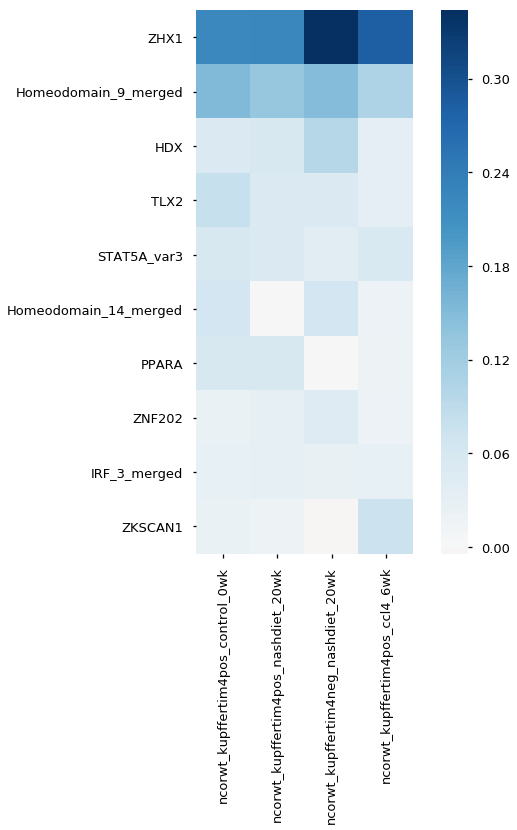

In [58]:
weights = mean_weights_frame.reindex(mean_weights_frame.mean(1).sort_values(ascending=False).index)
weights = weights.drop('BCL6B')
weights = weights.iloc[:10, :]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(weights.loc[:, samp_order],
     center=0,
     cmap='RdBu',
     square=True,
     ax=ax)
pos = hm.get_position()

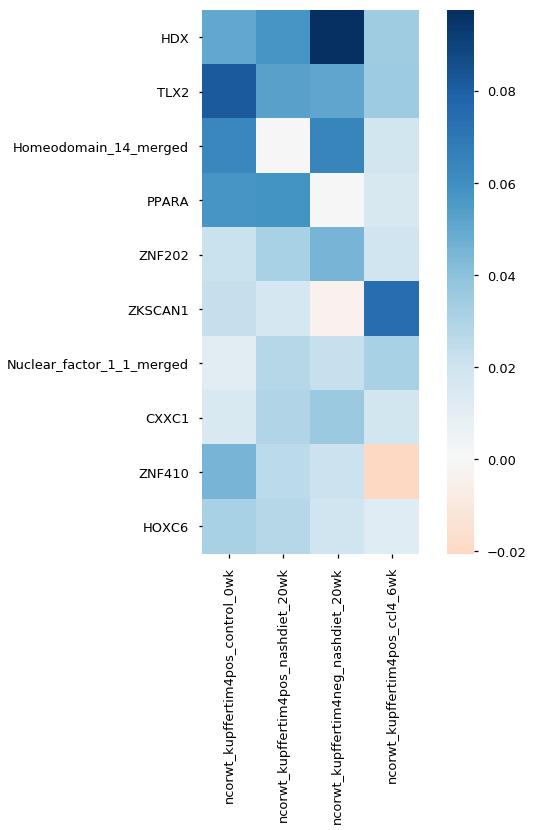

In [59]:
# select TFs of interest for plotting

# option: select TFs assigned weights by every LASSO model
# weights = mean_weights_frame.loc[(mean_weights_frame != 0).all(1), :]
# option: select TFs with a 2 fold change in magnitude across samples
# have to combine this with a minimum threshold bc if all 0's but also one very low weight then this will be infinite
weights = mean_weights_frame.loc[(np.abs(mean_weights_frame).max(1) / np.abs(mean_weights_frame).min(1) >= 2), :]
weights = weights.drop('BCL6B')

weights = weights.loc[(np.abs(mean_weights_frame) >= 0.01).any(1), :]
weights = weights.reindex(weights.mean(1).sort_values(ascending=False).index)
weights = weights.iloc[:10, :]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(weights.loc[:, samp_order],
     center=0,
     cmap='RdBu',
     square=True,
     ax=ax)
pos = hm.get_position()

# Repeat Analysis with Fold Changes 

### Merge All ATAC IDR Peaks

In [93]:
%%bash
if [ ! -d ./atac_merged/ ]; then mkdir ./atac_merged; fi
if [ ! -d ./tba_atac_merged/ ]; then mkdir ./tba_atac_merged; fi
# combine peaks
mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_merged/idr_peaks_merged.tsv
# annotate with h3k27ac signal
annotatePeaks.pl ./atac_merged/idr_peaks_merged.tsv mm10 -nogene -noann -d ./tag_directories_h3k27ac/* > idr_peaks_merged_ann.tsv
# use getDifferentialPeaks to get fold changes
# getDifferentialPeaks idr_peaks_merged_ann.tsv
# create bed file
pos2bed.pl ./atac_merged/idr_peaks_merged.tsv > ./atac_merged/idr_peaks_merged.bed
# extract sequence
/home/h1bennet/code/tba/model_training/extract_sequences_with_id.py ./atac_merged/idr_peaks_merged.bed mm10 ./atac_merged/idr_peaks_merged.fasta

reading genome mm10


	Max distance to merge: 100 bp
	Merging peaks... 
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_ccl4_6wk_peaks.tsv (29539 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_control_0wk_peaks.tsv (54773 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_control_20wk_peaks.tsv (32958 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4neg_nashdiet_20wk_peaks.tsv (40741 total) and ./atac_idr_peaks/ncorwt_kupffertim4pos_nashdiet_20wk_peaks.tsv (32811 total)
	Comparing ./atac_idr_peaks/ncorwt_kupffertim4pos_ccl4_6wk_peaks.tsv (29539 total) and ./atac_idr_peaks/ncorwt_ku

In [91]:
# get target positions
target_positions = read_target_positions(
    './atac_merged/idr_peaks_merged.bed',
    ['chrM', 'chrY'])

# calculate background positions
background_positions = get_random_background(
    target_positions,
    size_ratio=1.0, num_bins=10,
    n_threshold=0.1, genome='mm10')

# write out background positions - creates bed and fasta
background_positions_id = write_background_positions(
    background_positions,
    './atac_merged/')

# rename files
os.rename('./atac_merged/background.fasta',
          './atac_merged/'+bed.replace('.bed', '_background.fasta'))
os.rename('./atac_merged/background.bed',
          './atac_merged/'+bed.replace('.bed', '_background.bed'))

filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.3961042497220438 background GC: 0.39424917196111997 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.44532086496666506 background GC: 0.4409186643012094 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.47213217156956 background GC: 0.46533816319569843 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.4937398153342212 background GC: 0.48552024434787183 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5134610759470247 background GC: 0.5055657755599088 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5338680674472743 background GC: 0.5238394347487346 target length: 135 numTargetPositions 6731 backgroundPositions 6731
0 0
target GC: 0.5575864490671372 background GC: 0.546137493773263 target length: 135 numTargetPositions 6731 backgro

In [94]:
# score all peaks
create_features('./atac_merged/idr_peaks_merged.fasta',
                './tba_atac_merged',
                '/home/h1bennet/code/tba/default_motifs/',
                num_processors=40)

computing features for all sequences
Ahr::Arnt calculation time: 11.161368131637573
Arid3a calculation time: 11.370743036270142
BBX calculation time: 10.48576307296753
ARNT::HIF1A calculation time: 12.823474884033203
C2H2_ZF_5_merged calculation time: 9.002856492996216
Atf3 calculation time: 12.88105821609497
ARID5B_var2 calculation time: 15.378919124603271
AHR_var2 calculation time: 16.342332363128662
Arid3b calculation time: 14.557219505310059
BARHL2 calculation time: 14.200819492340088
C2H2_ZF_12_merged calculation time: 12.537241220474243
C2H2_ZF_2_merged calculation time: 12.734785556793213
BACH1_var4 calculation time: 15.672464847564697
AP-2_1_merged calculation time: 18.11534810066223
ATF2_var2 calculation time: 18.606200218200684
ATF4 calculation time: 18.492525577545166
C2H2_ZF_3_merged calculation time: 14.261069059371948
BARX2 calculation time: 17.352370738983154
BATF::JUN calculation time: 17.01750111579895
Arid5a calculation time: 18.02421498298645
ARNT2 calculation time: 

IRF6 calculation time: 14.320337295532227
Homeodomain_8_merged calculation time: 19.66226816177368
Homeodomain_7_merged calculation time: 21.57353138923645
ISL1 calculation time: 13.747240543365479
KLF9 calculation time: 11.34036111831665
LIN54 calculation time: 9.023148536682129
Hoxd8 calculation time: 21.02960443496704
INSM1 calculation time: 20.627970933914185
Jun-related_factors_2_merged calculation time: 15.870074987411499
IRF4 calculation time: 20.36889362335205
MEIS1 calculation time: 9.794944286346436
LCOR calculation time: 13.175729990005493
IRF3 calculation time: 22.97382426261902
MAFG::NFE2L1 calculation time: 12.761936664581299
IRF5_var2 calculation time: 22.364154815673828
IRF4_var3 calculation time: 22.8601336479187
KLF8 calculation time: 18.9280948638916
KLF15 calculation time: 20.31207036972046
MXI1_var3 calculation time: 12.727536678314209
IRF7 calculation time: 24.023459911346436
IRF5_var3 calculation time: 24.547619581222534
MYF6 calculation time: 11.641116380691528


SOX18_var4 calculation time: 28.344448804855347
STAT_1_merged calculation time: 23.88558316230774
TERF2 calculation time: 9.41674280166626
Spz1 calculation time: 18.65411877632141
TAL1::TCF3 calculation time: 15.891749143600464
Sox_7_merged calculation time: 19.5758159160614
Six3 calculation time: 25.37225079536438
TBrain-related_factors_2_merged calculation time: 14.698771238327026
TBX2-related_factors_1_merged calculation time: 15.647159099578857
TBP calculation time: 15.956623077392578
TLX2 calculation time: 9.6759614944458
TEF-1-related_factors_1_merged calculation time: 14.207170724868774
Sox_3_merged calculation time: 22.961191415786743
TALE-type_homeo_domain_factors_1_merged calculation time: 17.722068548202515
STAT1::STAT2 calculation time: 28.883781909942627
TCF-7-related_factors_1_merged calculation time: 15.751709699630737
TALE-type_homeo_domain_factors_2_merged calculation time: 19.209816217422485
Sox_4_merged calculation time: 24.04395580291748
TBrain-related_factors_1_mer

### calculate fold changes - these will be the labels

In [134]:
tags = pd.read_csv('./atac_merged/idr_peaks_merged_ann.tsv', sep='\t', index_col=0)
tags.index.rename('peakID', inplace=True)

In [138]:
tags.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size',
       './tag_directories_h3k27ac/C57BL6_KupfferTim4Neg_ChIP_H3K27Ac_nashdiet_20wk_C579AC Tag Count in given bp (20981542.0 Total, normalization factor = 0.48, effective total = 10000000)',
       './tag_directories_h3k27ac/C57BL6_KupfferTim4Pos_ChIP_H3K27Ac_CCl4_6wk_NSL105C Tag Count in given bp (22145840.0 Total, normalization factor = 0.45, effective total = 10000000)',
       './tag_directories_h3k27ac/C57BL6_KupfferTim4Pos_ChIP_H3K27Ac_CCl4_6wk_NSL112 Tag Count in given bp (21133267.0 Total, normalization factor = 0.47, effective total = 10000000)',
       './tag_directories_h3k27ac/C57BL6_KupfferTim4Pos_ChIP_H3K27ac_Control_0wk_13 Tag Count in given bp (9468035.0 Total, normalization factor = 1.06, effective total = 10000000)',
       './tag_directories_h3k27ac/C57BL6_KupfferTim4Pos_ChIP_H3K27Ac_Control_0wk_14 Tag Count in given bp (22615879.0 Total, normalization factor = 0.44, effective tota

In [139]:
tim4pos_nash = pd.Series(tags.columns).str.contains('.*Tim4Pos.*nash.*', regex=True)
tim4neg_nash = pd.Series(tags.columns).str.contains('.*Tim4Neg.*nash.*', regex=True)
tim4pos_control = pd.Series(tags.columns).str.contains('.*Tim4Pos.*Control.*', regex=True)
tim4pos_ccl4 = pd.Series(tags.columns).str.contains('.*Tim4Pos.*CCl4.*', regex=True)

In [141]:
tim4pos_amln_fc = tags.loc[:, tim4pos_nash.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)
tim4neg_amln_fc = tags.loc[:, tim4neg_nash.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)
tim4pos_ccl4_fc = tags.loc[:, tim4pos_ccl4.values].mean(1) / (tags.loc[:, tim4pos_control.values].mean(1) + 1)

In [142]:
tim4pos_amln_fc.to_csv('./tba_atac_merged/tim4pos_amln_fc_labels.tsv', sep='\t')
tim4neg_amln_fc.to_csv('./tba_atac_merged/tim4neg_amln_fc_labels.tsv', sep='\t')
tim4pos_ccl4_fc.to_csv('./tba_atac_merged/tim4pos_ccl4_fc_labels.tsv', sep='\t')

# Run model on h3k27ac fold changes

In [146]:
features = pd.read_csv('./tba_atac_merged/idr_peaks_merged_features.tsv', sep='\t', index_col=0)

In [195]:
tim4pos_ccl4_fc = tim4pos_ccl4_fc.reindex(features.index)

In [196]:
training_features, test_features, training_labels, test_labels = train_test_split(
    features,
    tim4pos_ccl4_fc,
    train_size=0.5)

In [202]:
scaler = preprocessing.StandardScaler()

# standardize training features
standardized_training_features = pd.DataFrame(scaler.fit_transform(training_features))
standardized_training_features.columns = training_features.columns.values
standardized_training_features.index = training_features.index.values

# standardize test features
standardized_test_features = pd.DataFrame(scaler.fit_transform(test_features))
standardized_test_features.columns = test_features.columns.values
standardized_test_features.index = test_features.index.values

#  Train affinity classifier
# classifier = sklearn.linear_model.LinearRegression(fit_intercept=False, normalize=False)
classifier = sklearn.linear_model.Lasso(alpha=0.025, fit_intercept=False, normalize=False)
classifier.fit(standardized_training_features, training_labels)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [203]:
import scipy
predictions=classifier.predict(test_features)
scipy.stats.pearsonr(predictions.flatten(), test_labels.values.flatten())

(0.18678682508421976, 7.1395994822837914e-262)

### Scan Parameters Alpha

In [29]:
os.listdir('./tba_atac_merged/')

['tim4pos_ccl4_fc_coefficients.tsv',
 'tim4pos_amln_fc_performance.tsv',
 'tim4pos_ccl4_fc_significance.tsv',
 'tim4pos_ccl4_fc_performance.tsv',
 'tim4pos_amln_fc_coefficients.tsv',
 'tim4pos_amln_fc_significance.tsv',
 'tim4neg_amln_fc_significance.tsv',
 'tim4neg_amln_fc_coefficients.tsv',
 'idr_peaks_merged_motif_scores.tsv',
 'idr_peaks_merged_features.tsv',
 'tim4pos_amln_fc_labels.tsv',
 'tim4pos_ccl4_fc_labels.tsv',
 'tim4neg_amln_fc_labels.tsv',
 'idr_peaks_merged_motif_starts.tsv',
 'tim4neg_amln_fc_performance.tsv']

In [33]:
if not os.path.isdir('./tba_atac_merged_alpha_eval/'):
    os.mkdir('./tba_atac_merged_alpha_eval/')
fc = 'tim4pos_amln_fc_labels.tsv'
pearson = []
coef = []
print('assessing sample:', fc)
for alpha in np.arange(0, 1, 0.05):
    print('training model with alpha:', alpha)
    run_train_classifier('./tba_atac_merged/idr_peaks_merged_features.tsv',
                         './tba_atac_merged/' + fc,
                         output_path='./tba_atac_merged/',
                         num_iterations=3,
                         alpha=alpha)

    os.rename('./tba_atac_merged/idr_peaks_merged_significance.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'significance'))

    os.rename('./tba_atac_merged/idr_peaks_merged_performance.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'performance'))
    os.rename('./tba_atac_merged/idr_peaks_merged_coefficients.tsv',
              './tba_atac_merged_alpha_eval/' + fc.replace('labels', 'coefficients'))

assessing sample: tim4pos_amln_fc_labels.tsv
training model with alpha: 0.0
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1


/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


running f test
iteration training time: 16.058541774749756 pearson r 0.236508749905
training iteration: 2
running f test
iteration training time: 15.298060417175293 pearson r 0.238947288501
training iteration: 3
running f test
iteration training time: 16.227720975875854 pearson r 0.231283249603
Total time: 49.76170253753662
writing results
training model with alpha: 0.05
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 15.30421781539917 pearson r 0.240336000591
training iteration: 2
running f test
iteration training time: 14.40615177154541 pearson r 0.241565561305
training iteration: 3
running f test
iteration training time: 15.180947303771973 pearson r 0.242986796997
Total time: 46.82310175895691
writing results
training model with alpha: 0.1
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f t

training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 16.261305570602417 pearson r 0.23988137701
training iteration: 2
running f test
iteration training time: 16.072800636291504 pearson r 0.238053490135
training iteration: 3
running f test
iteration training time: 15.415557146072388 pearson r 0.239944654178
Total time: 49.727224826812744
writing results
training model with alpha: 0.9
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1
running f test
iteration training time: 16.973182439804077 pearson r 0.233931036511
training iteration: 2
running f test
iteration training time: 15.703432559967041 pearson r 0.232413103375
training iteration: 3
running f test
iteration training time: 13.357443809509277 pearson r 0.232912920031
Total time: 47.816884994506836
writing results
training model with alpha: 0.95
reading features and labels
training

### Run the model

In [28]:
for fc in os.listdir('./tba_atac_merged/'):
    if 'labels' in fc:
        print('training model on:', fc)
        run_train_classifier('./tba_atac_merged/idr_peaks_merged_features.tsv',
                             './tba_atac_merged/' + fc,
                             output_path='./tba_atac_merged/',
                             num_iterations=1,
                             alpha=1)

        os.rename('./tba_atac_merged/idr_peaks_merged_significance.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'significance'))

        os.rename('./tba_atac_merged/idr_peaks_merged_performance.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'performance'))
        os.rename('./tba_atac_merged/idr_peaks_merged_coefficients.tsv',
                  './tba_atac_merged/' + fc.replace('labels', 'coefficients'))

training model on: tim4pos_amln_fc_labels.tsv
reading features and labels
training classifier for ./tba_atac_merged/idr_peaks_merged_features.tsv
training iteration: 1


/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


KeyboardInterrupt: 

### read in weight values

In [118]:
sample_weights_dict = {}
for f in os.listdir('./tba_atac_merged/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_atac_merged/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:4])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [119]:
sample_pval_dict = {}
for f in os.listdir('./tba_atac_merged/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_atac_merged/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:4])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

In [120]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,450)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=200,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=200,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')

    plt.savefig('./figures/tba_s_plot.pdf',bbox_inches='tight')

KeyError: 'tim4neg_amln_fc_significance.tsv'

### Create Heatmap of differential motifs

In [116]:
pseudocount = 1e-10 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]

# create heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=12, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);
plt.savefig('./figures/tba_heatmap.pdf',bbox_inches='tight')

KeyError: 'tim4neg_amln_fc_significance.tsv'

## Compare HOMER Results to TBA

### Run Get Differential Peaks

In [26]:
%%bash
# delete the existing script file
rm ./run_getDifferentialPeaks.sh
# create a script file
touch ./run_getDifferentialPeaks.sh

# if directories don't exist, create them
if [ ! -d ./diff_peaks/ ]; then mkdir ./diff_peaks; fi

In [27]:
import itertools
# write differential peaks and merge peaks commands
with open('./run_getDifferentialPeaks.sh', 'w') as f:
    # write differential peaks and merge peaks commands
    # merge peaks into one file
    f.write('mergePeaks -d 100 ./atac_idr_peaks/*peaks.tsv > ./atac_idr/ncorwt_atac_merged_peaks.tsv\n')
    # merge tag directories for getDifferential peaks
    mylist=rename_dict.keys()
    merged_peaks=[]
    for i, j in itertools.combinations(mylist, r=2):
        if (i.split('_ATAC')[0] == j.split('_ATAC')[0]):
            # create output file name for merging peaks
            out_file = [x for x in i.split('_') if x in set(j.split('_'))]
            out_file = '_'.join(out_file)+'_merged_tag_dir'
            merge_peaks = ['makeTagDirectory', './tag_directories_atac/'+out_file,
                           '-d', './tag_directories_atac/'+i,
                           './tag_directories_atac/'+j+'\n']
            f.write(' '.join(merge_peaks))
            merged_peaks.append(out_file)
            
    # run get differential peaks
    for i, j in itertools.combinations(merged_peaks, r=2):
        get_diff = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+j, 
                    './tag_directories_atac/'+i, '>',
                    './diff_peaks/'+j+'_vs_'+i+'_diffpeaks.tsv\n']
        get_diff_rev = ['getDifferentialPeaks', './atac_idr/ncorwt_atac_merged_peaks.tsv',
                    './tag_directories_atac/'+i, 
                    './tag_directories_atac/'+j, '>',
                    './diff_peaks/'+i+'_vs_'+j+'_diffpeaks.tsv\n']
        f.write(' '.join(get_diff))
        f.write(' '.join(get_diff_rev))

In [28]:
# next up implement homer get differential motifs!

In [ ]:
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4neg_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ncorwt_kupffertim4pos_nashdiet_21wk_peaks_distal/ -size 200 -len 10,12,14

In [31]:
%%bash
# if directories don't exist, create them
if [ ! -d ./find_motifs/ ]; then mkdir ./find_motifs; fi

for diffpeak in ./atac_idr_peaks_other/*distal.tsv;
do echo findMotifsGenome.pl $diffpeak mm10 ./find_motifs/ -size 200 -len 10,12,14;
done

findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_bloodly6chi_controldiet_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4neg_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14
findMotifsGenome.pl ./atac_idr_peaks_other/ncorwt_kupffertim4pos_nashdiet_21wk_peaks_distal.tsv mm10 ./find_motifs/ -size 200 -len 10,12,14


### we can also try finding motifs with just the distal atac peak files

In [30]:
# # table this for now - can use to switch to doing homer on distal peaks only
# %%bash
# # get distal peaks since we are mainly interested in enhancers
# for peak_file in ./atac_idr_peaks/*;
# do dist_file=${peak_file/.tsv/_distal.tsv};
# echo $dist_file
# getDistalPeaks.pl $peak_file mm10 > $dist_file;
# done

### Process denovo motif results and read into data frame for analysis

In [41]:
import codecs
# p values stored at the 9 + 8n cells
# names of TFs stored at the 13 + 8n cells
denovo_results = {}
for homerfile in os.listdir('./find_motifs/'):
    tf_logp_dict = {}
    # open homer file
    if not homerfile.startswith('.'):
        f = codecs.open(
            './find_motifs/' + homerfile + '/homerResults.html', 'r')
        denovo = f.read().split('</TD><TD>')
        # table is in columns of 8
        # log p value is at position 9 + 8n
        # tf name is at position 13 + 8n
        for i in range(len(denovo) // 8):
            tf = denovo[13 + 8*i].split('/')[0]
            tf_2 = tf.split('(')[0]
            tf_logp_dict[tf_2] = denovo[9 + 8*i]
        denovo_results[homerfile] = tf_logp_dict
            
        
# create matrix of de novo motif log ps
denovo_logp = -pd.DataFrame(denovo_results, dtype=float).fillna(0)
# set max to 50 so its more comparable to tba
denovo_logp[denovo_logp > 50] = 50
# sort based on mean value
denovo_logp = denovo_logp.reindex(index=denovo_logp.mean(1).sort_values(ascending=False).index)

FileNotFoundError: [Errno 2] No such file or directory: './find_motifs/'

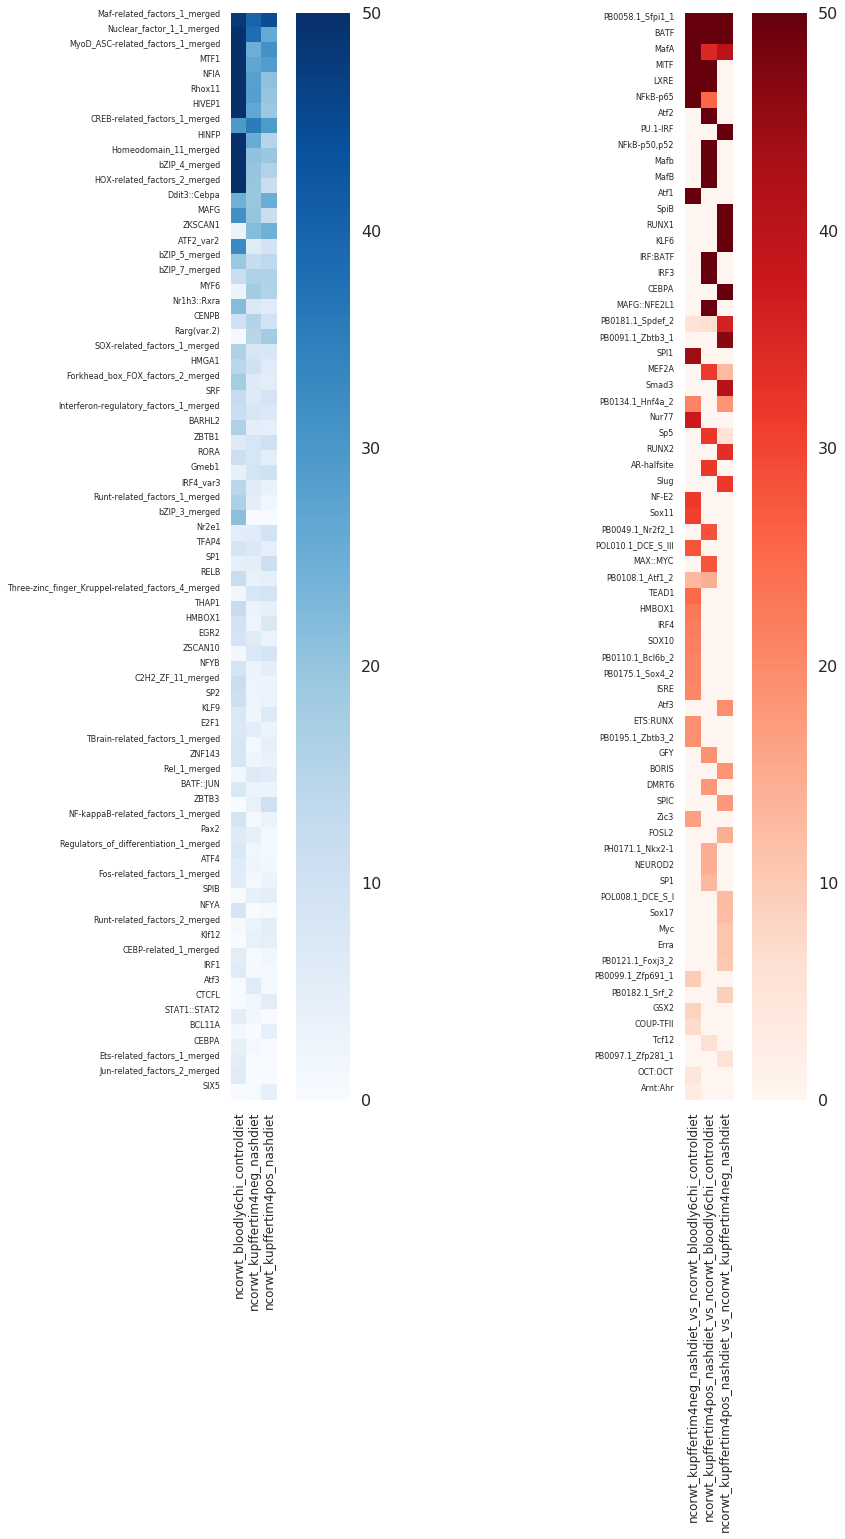

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,20), sharey=False)
hm = sns.heatmap(filtered_frame,
     vmin=0,
     cmap='Blues',
     square=True,
     ax=ax1)
pos = hm.get_position()

hm.set_yticks(range(0, filtered_frame.shape[0]));
hm.set_yticklabels(size=8, labels = filtered_frame.index.values[::-1]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

hm2 = sns.heatmap(denovo_logp,
     vmin=0,
     cmap='Reds',
     square=True,
     ax=ax2)
pos = hm2.get_position()

hm2.set_yticks(range(0, denovo_logp.shape[0]));
hm2.set_yticklabels(size=8, labels = denovo_logp.index.values,
                    verticalalignment='top');
hm2.set_xticklabels(size=12, labels = denovo_logp.columns.values, rotation=90);

# Integrate RNA Seq Data

## Process RNA Seq Data

### RNA QC

In [27]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [28]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    if not any(fname.endswith('.log') for fname in os.listdir('./tag_directories_rna/'+sample+'/')):
        print(sample + ' does not contain a mapping log file')
        qc_stats.loc[sample, 'totalReads'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
        qc_stats.loc[sample, 'multiMappedReads'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
        qc_stats.loc[sample, 'mappedFraction'] = np.nan

qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

C57Bl6_KupfferTim4Pos_RNA_Control_0wk_NNaF does not contain a mapping log file
C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM does not contain a mapping log file


### Annotate and Compile RNA

In [106]:
%%bash
# if directories don't exist, create them
if [ ! -d ./expression/ ]; then mkdir ./expression; fi

#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
#analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_3
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_6and10
		./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_8
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Neg_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1C
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_CCl4_6wk_CC1D
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_NNaF
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_20wk_LN196cM

In [107]:
%%bash
#makeMultiWigHub.pl hrb_kupffer_21wk_rna mm10 -force -d ./tag_directories_rna/*


	Once finished, you will want to upload the following hub URL:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/hub.txt

	If loading to the Wash U Epigenome Browser, use:
		http://homer.ucsd.edu/hubs//hrb_kupffer_21wk_rna/washU.hub.txt

	Overwriting contents in /homer_data/www/html/hubs//hrb_kupffer_21wk_rna

	Visualization fragment length = 75
	Output file: ./tag_directories_rna/C57B6J_Ly6cHi_RNA_NoTx_3/C57B6J_Ly6cHi_RNA_NoTx_3.ucsc.bigWig
	No need to remove tags to get desired file size
	Generating bedGraph for chr1
	Generating bedGraph for chr10
	Generating bedGraph for chr11
	Generating bedGraph for chr12
	Generating bedGraph for chr13
	Generating bedGraph for chr14
	Generating bedGraph for chr15
	Generating bedGraph for chr16
	Generating bedGraph for chr17
	Generating bedGraph for chr18
	Generating bedGraph for chr19
	Generating bedGraph for chr2
	Generating bedGraph for chr3
	Generating bedGraph for chr4
	Generating bedGraph for chr5
	Generating bedGraph for chr6
	Generating b

### RNA Data Wrangling
______
Goal is to get average expression of each transcription factor in dataset for each sample group

In [29]:
# import RNA Seq data
exp = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t', index_col=0)
exp.index.rename('refseq_id', inplace=True)
exp['gene'] = exp['Annotation/Divergence'].str.split('|').str[0]

# filter based on gene expression
exp_filt = ((exp.iloc[:, 7:-1] != 0).sum(1) == exp.shape[1]-8)
exp = exp.loc[exp_filt, :]

#filter based on length
exp = exp.loc[exp.Length >= 250, :]

# create average expression matrix
exp_avg = pd.DataFrame([exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Control_0wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('Control_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Pos_RNA_AMLNDiet_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Neg_RNA_AMLNDiet_20wk'))].mean(1),
                        exp.loc[:, list(pd.Series(exp.columns.values).str.contains('KupfferTim4Pos_RNA_CCl4_6wk'))].mean(1)],
                        index=['ncorwt_tim4pos_control_0wk', 'ncorwt_kupffertim4pos_control_20wk', 
                               'ncorwt_kupffertim4pos_nashdiet_20wks', 'ncorwt_kupffertim4neg_nashdiet_20wk',
                               'ncorwt_kupffertotal_ccl4_6wk']).T

# filter on average expression
avg_filt = (exp_avg > 10).any(1)
exp_avg = exp_avg.loc[avg_filt, :]

# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt',
                          sep='\t', names=['refseq_id', 'gene'],
                          index_col=0)
#merge to annotate dataset
exp_avg = exp_avg.merge(mm10_refseq, right_index=True,
              left_index=True, how='left')
# change index to gene name
exp_avg = exp_avg.set_index('gene')

# import jenhan's TF family to gene name file
motif_gene_dict = {}
with open('./motifGene_v2.txt') as f:
    for line in f:
        (key, val) = line.split()
        motif_gene_dict[key] = val

# convert motif/score frame to a tf/score frame
tf_score_dict = {}
for index, row in frame.iterrows():
    if index in motif_gene_dict.keys():
        for tf in re.split('\||::', motif_gene_dict[index]):
            tf_score_dict[tf.upper()] = row.values
            
tf_score_frame = pd.DataFrame(tf_score_dict, index=frame.columns).T

### Plot Data

In [43]:
# import linear regression module
import statsmodels.formula.api as sm

# define function for labeling points on scatter
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=12)

### tim4pos nash vs tim4pos 0wk control

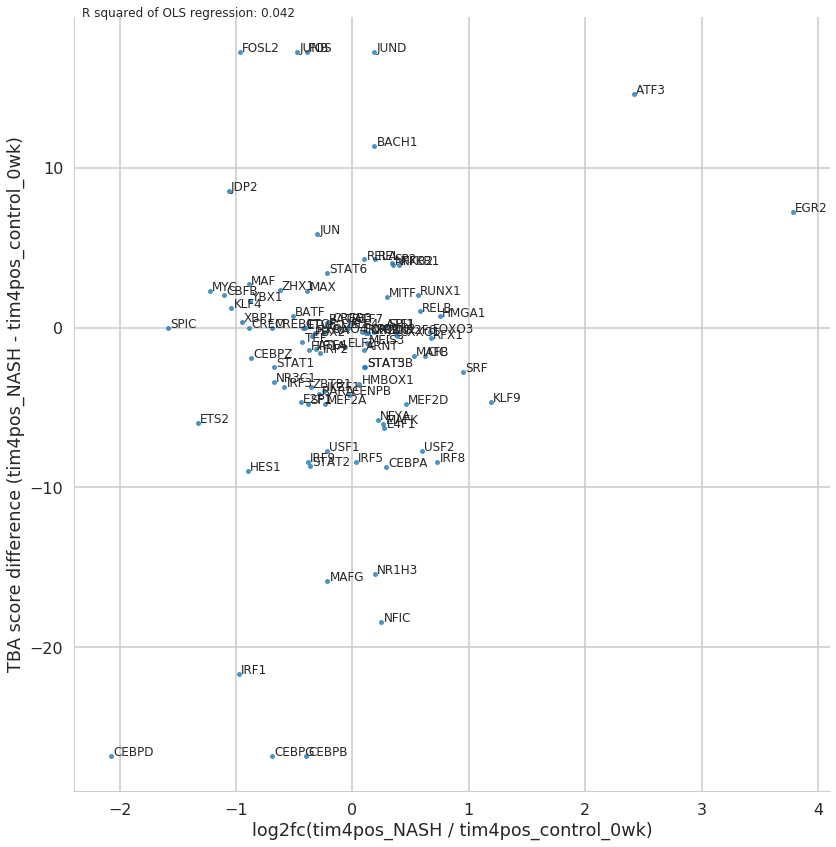

In [95]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos_NASH / tim4pos_control_0wk)', 'TBA score difference (tim4pos_NASH - tim4pos_control_0wk)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4pos_nash_tim4pos_control_0wk_loglog_plot.pdf', bbox_inches='tight')

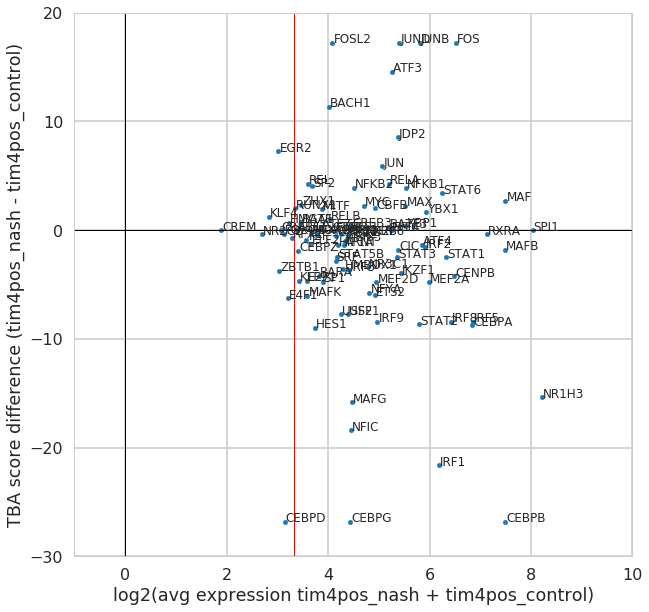

In [96]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4pos_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,20])

plt.savefig('./figures/tim4pos_nash_tim4pos_control_0wk_MAplot.pdf', bbox_inches='tight')

### tim4pos nash vs. tim4pos 20wk control

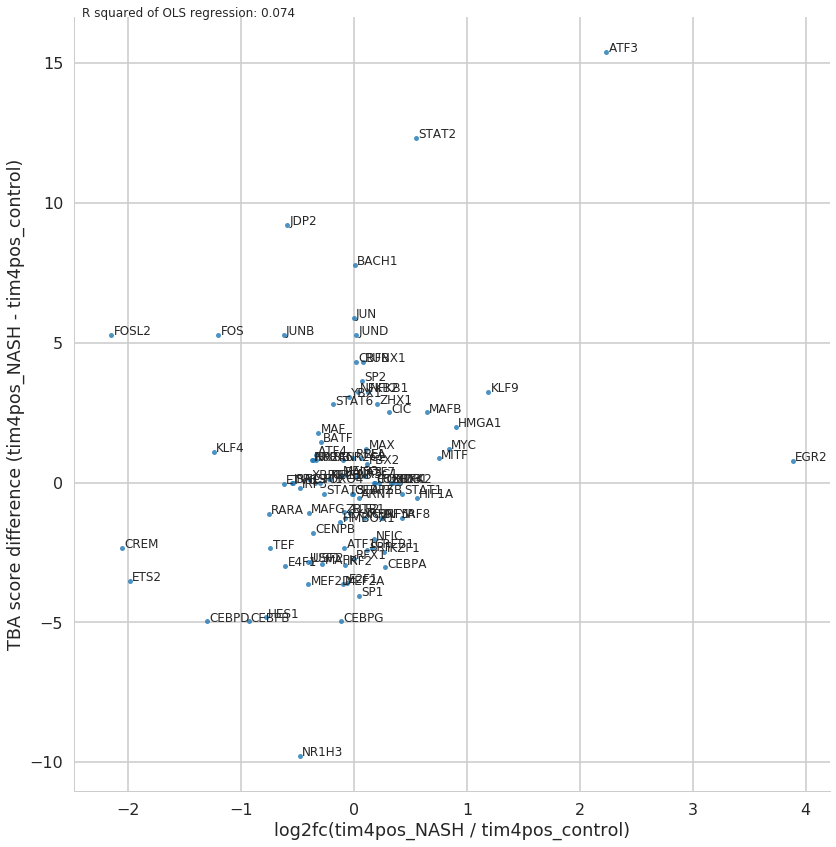

In [97]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_kupffertim4pos_control_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos_NASH / tim4pos_control)', 'TBA score difference (tim4pos_NASH - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4pos_nash_tim4pos_control_20wk_loglog_plot.pdf', bbox_inches='tight')

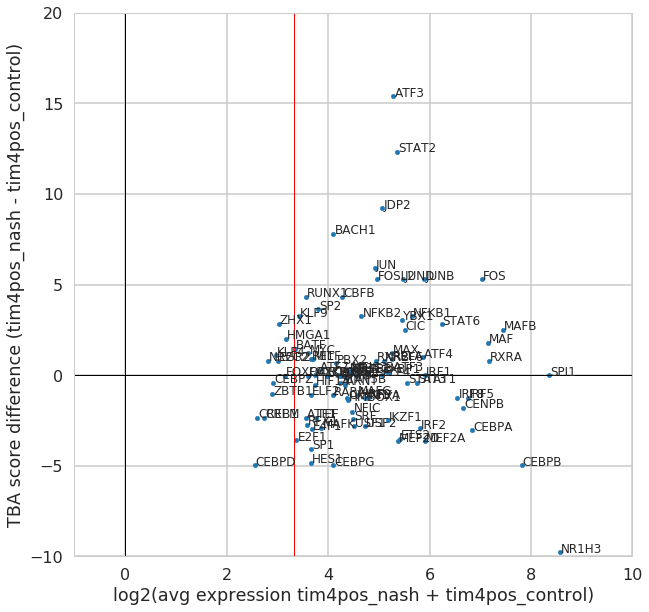

In [98]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4pos_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-10,20])

plt.savefig('./figures/tim4pos_nash_tim4pos_control_20wk_MAplot.pdf', bbox_inches='tight')

### Tim4Neg vs 0 wk control

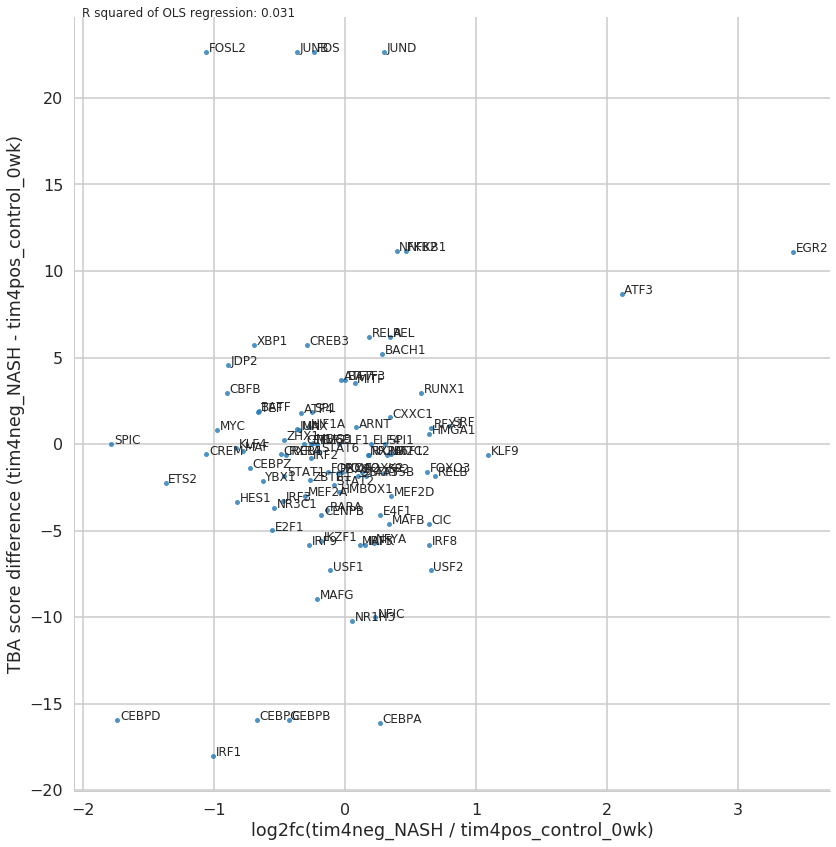

In [108]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg_NASH / tim4pos_control_0wk)', 'TBA score difference (tim4neg_NASH - tim4pos_control_0wk)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4neg_nash_tim4pos_control_0wk_loglog_plot.pdf', bbox_inches='tight')

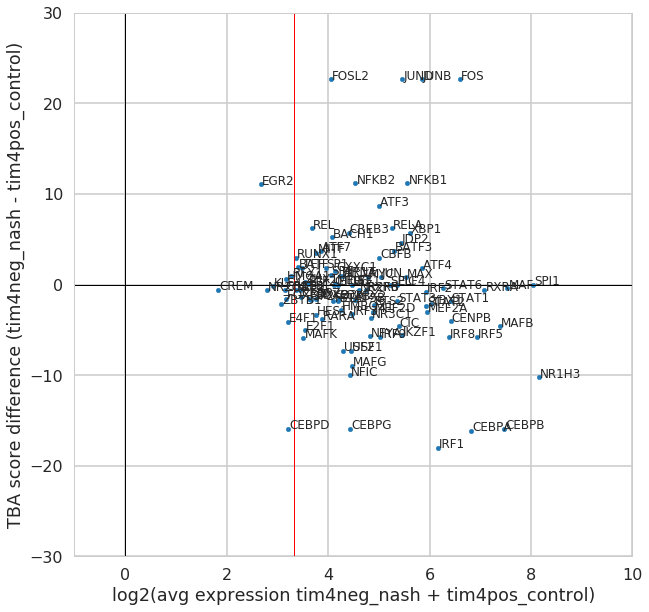

In [109]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg_nash + tim4pos_control)')
plt.ylabel('TBA score difference (tim4neg_nash - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,30])

plt.savefig('./figures/tim4neg_nash_tim4pos_control_0wk_MAplot.pdf', bbox_inches='tight')

### Tim4Neg vs 20 wk control

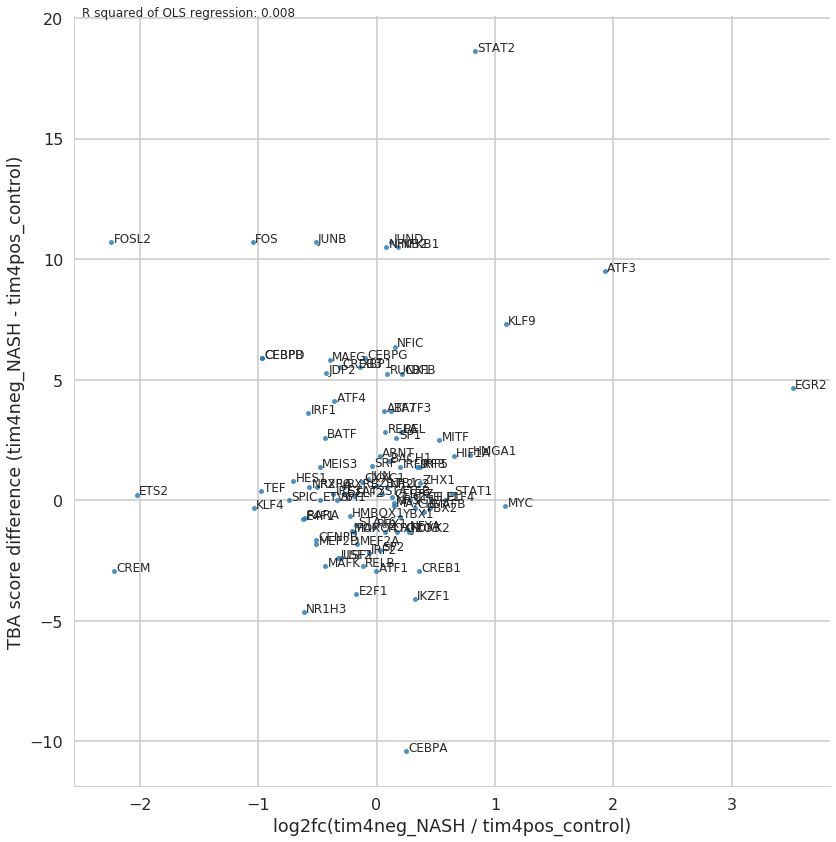

In [101]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
samp2 = 'ncorwt_kupffertim4pos_control_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4neg_NASH / tim4pos_control)', 'TBA score difference (tim4neg_NASH - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/tim4neg_nash_tim4pos_control_20wk_loglog_plot.pdf', bbox_inches='tight')

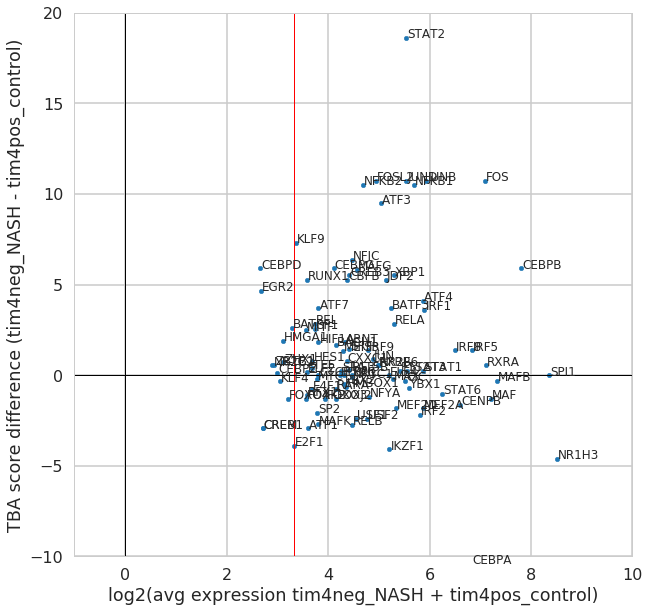

In [102]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4neg_NASH + tim4pos_control)')
plt.ylabel('TBA score difference (tim4neg_NASH - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-10,20])

plt.savefig('./figures/tim4neg_nash_tim4pos_control_20wk_MAplot.pdf', bbox_inches='tight')

### CCl4 vs 0 wk control

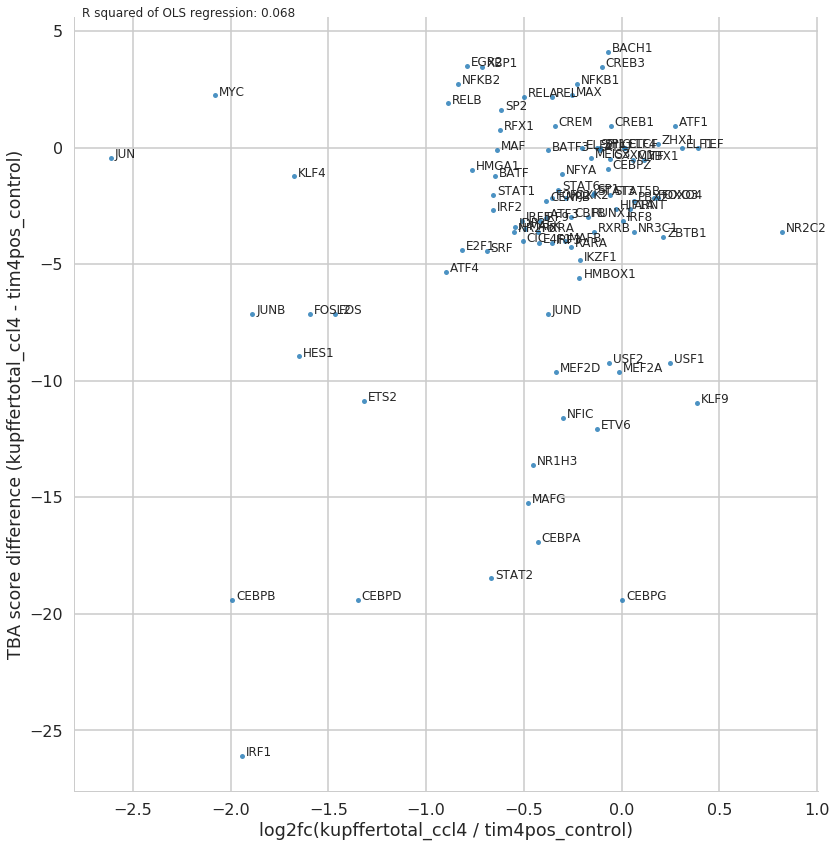

In [110]:
## create temporary frame with sample data
samp1 = 'ncorwt_kupffertotal_ccl4_6wk'
samp2 = 'ncorwt_tim4pos_control_0wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(kupffertotal_ccl4 / tim4pos_control)', 'TBA score difference (kupffertotal_ccl4 - tim4pos_control)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)

plt.savefig('./figures/kupffertot_ccl4_vs_tim4pos_control_loglog_plot.pdf', bbox_inches='tight')

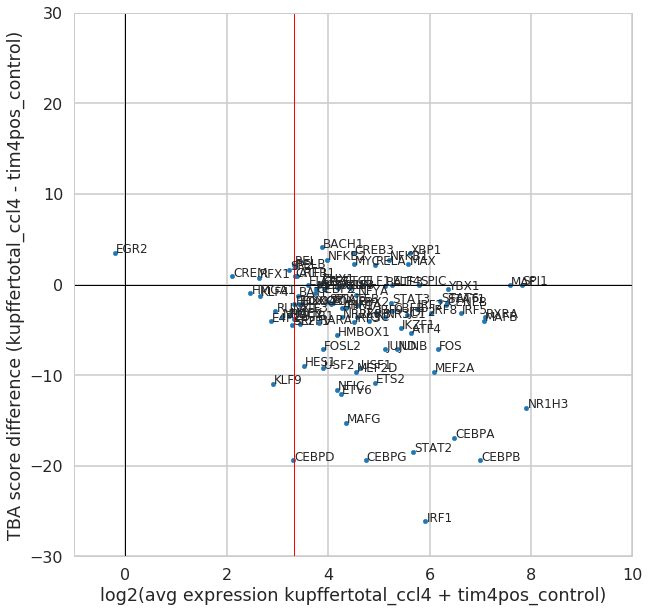

In [111]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression kupffertotal_ccl4 + tim4pos_control)')
plt.ylabel('TBA score difference (kupffertotal_ccl4 - tim4pos_control)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', lw=1)
plt.plot([0, 0], [-100, 100], color='k', lw=1)
plt.plot([-100, 100], [0, 0], color='k', lw=1)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-30,30])

plt.savefig('./figures/kupffertot_ccl4_vs_tim4pos_control_MAplot.pdf', bbox_inches='tight')

### Tim4Pos AMLN vs Tim4Neg AMLN

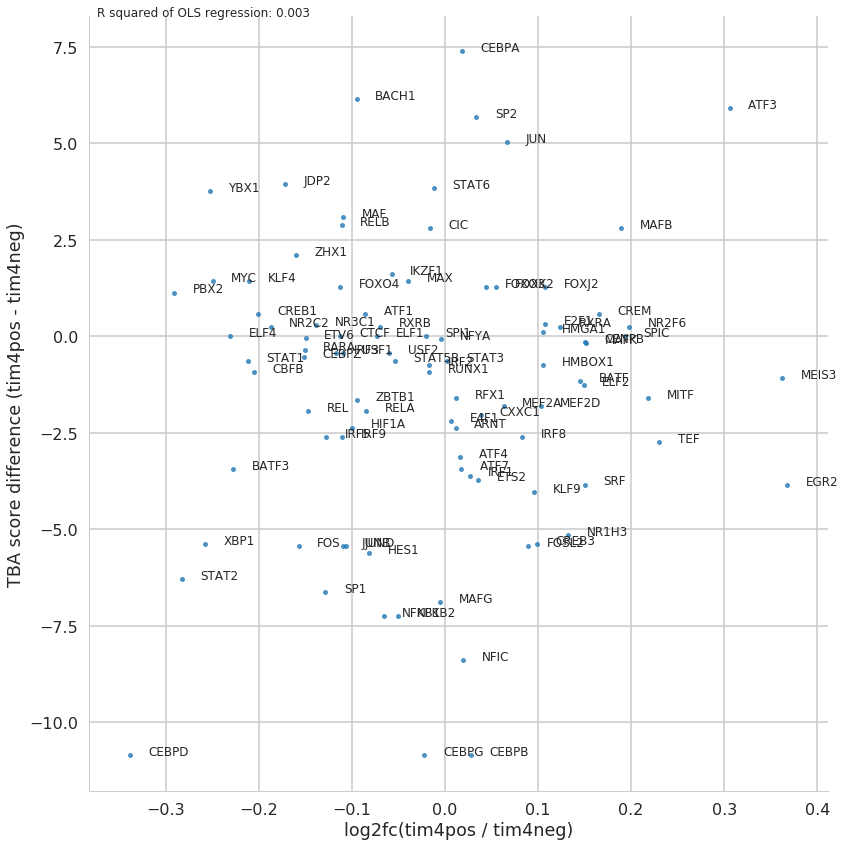

In [105]:
# create temporary frame with sample data
samp1 = 'ncorwt_kupffertim4pos_nashdiet_20wks'
samp2 = 'ncorwt_kupffertim4neg_nashdiet_20wk'
avg_exp = (exp_avg[samp1] + exp_avg[samp2])/2
avg_exp.index = pd.Series(avg_exp.index).str.upper()
log2fc = np.log2(exp_avg[samp1] / exp_avg[samp2])
log2fc.index = pd.Series(log2fc.index).str.upper()
sig_delta = tf_score_frame[samp1] - tf_score_frame[samp2]
tmp_frame = pd.merge(pd.merge(pd.DataFrame(avg_exp, columns=['avg_exp']),
                              pd.DataFrame(log2fc, columns=['log2fc']),
                              right_index=True, left_index=True,
                              how='inner'),
                     pd.DataFrame(sig_delta, columns=['sig_delta']),
                     right_index=True, left_index=True,
                     how='inner')


# plot scatter
fig = sns.lmplot(x='log2fc', y='sig_delta',
                 data=tmp_frame, size=12,
                 scatter_kws={'s': 25},
                 fit_reg=False)
fig.set_axis_labels('log2fc(tim4pos / tim4neg)', 'TBA score difference (tim4pos - tim4neg)')
label_point(tmp_frame.log2fc, tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

# calculate R^2
result = sm.ols(formula='sig_delta ~ log2fc', data=tmp_frame).fit()
plt.gca().annotate('R squared of OLS regression: %.3f' % result.rsquared,
             xy=(0.01, 1), xycoords='axes fraction', fontsize=12)
plt.savefig('./expression/tim4pos_tim4neg_loglog_plot.pdf', bbox_inches='tight')

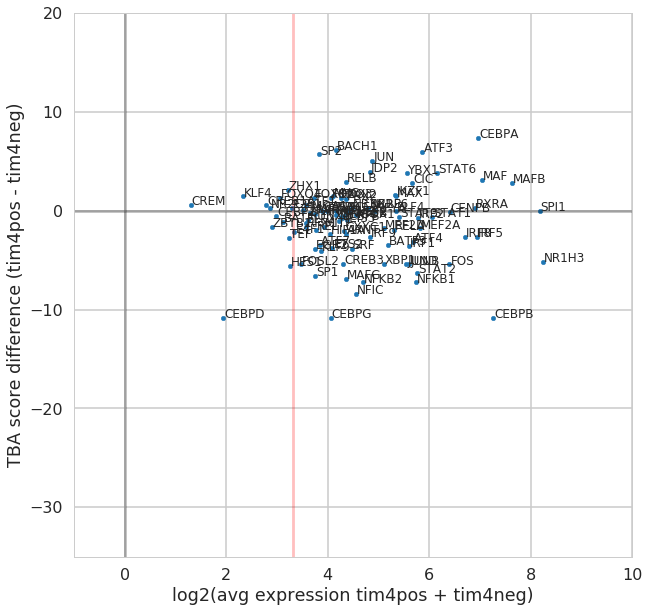

In [106]:
plt.figure(figsize=(10, 10))
plt.scatter(np.log2(tmp_frame.avg_exp),
            tmp_frame.sig_delta,
            s=20)
plt.xlabel('log2(avg expression tim4pos + tim4neg)')
plt.ylabel('TBA score difference (tim4pos - tim4neg)')

label_point(np.log2(tmp_frame.avg_exp), tmp_frame.sig_delta,
            pd.Series(tmp_frame.index, index=tmp_frame.index), plt.gca())

plt.plot([np.log2(10), np.log2(10)], [-100, 100], color='r', alpha=0.25)
plt.plot([0, 0], [-100, 100], color='k', alpha=0.25)
plt.plot([-100, 100], [0, 0], color='k', alpha=0.25)
axes=plt.gca()
axes.set_xlim([-1,10])
axes.set_ylim([-35,20])

plt.savefig('./expression/tim4pos_tim4neg_MAplot.pdf', bbox_inches='tight')

### Compare disease models?

### Create Table of top positively correlated motifs

In [377]:
pval_threshold = 1e-10
positive_motif_set = None
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]


    significant_positive_motifs = weights[weights>0].index.intersection(pvals[pvals < pval_threshold].index)
    if positive_motif_set == None:
        positive_motif_set = set(significant_positive_motifs)
    else:
        positive_motif_set = positive_motif_set.intersection(set(significant_positive_motifs)) 
data = mean_pval_frame.loc[sorted(positive_motif_set), :]

data = data+1e-50

positive_table = data[[]]
positive_table['Motif'] = data.index.values
positive_table['Mean p-val'] = data.mean(axis=1)
positive_table.sort_values(by='Mean p-val', inplace = True)
# positive_table.to_csv('./figures/postive_motif_table.tsv', sep='\t', index = False)
positive_table

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,Motif,Mean p-val
CTCF,CTCF,1.000000e-50
Klf12,Klf12,1.000000e-50
Ets-related_1_merged,Ets-related_1_merged,1.000000e-50
IRF1,IRF1,1.000000e-50
Ets-related_2_merged,Ets-related_2_merged,1.000001e-50
STAT1::STAT2,STAT1::STAT2,3.012751e-49
Atf3,Atf3,4.758546e-48
Gabpa,Gabpa,1.042895e-47
NFYA,NFYA,4.740630e-30
Pax2,Pax2,2.150195e-29
